In [1]:
%pylab inline
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import pandas as pd
import mdtraj as md
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


# coordinates

In [2]:
liganded_topfile = 'data/liganded_ca.pdb'
complex_topfile = 'data/complex_ca.pdb'
liganded_top = md.load(liganded_topfile)
complex_top = md.load(complex_topfile)
from glob import glob
liganded_list = glob('data/liganded/ca*.xtc')
complex_list = ['data/complex100/ca{}.xtc'.format(i) for i in range(2,12)]

In [3]:
v1_2 = range(99,153)#top.topology.select('resi 99 to 152 and name CA')
b_sheet = list(range(89,92))+list(range(168,171))+list(range(385,387))+list(range(394,396))
#top.topology.select('resi 89 to 92 or resi 168 to 171 or resi 385 to 387 or resi 394 to 396 and name CA')
a1 = range(69,85)#top.topology.select('resi 69 to 85 and name CA')
v3 = range(265,294)#top.topology.select('resi 265 to 294 and name CA')

In [4]:
def compute_center_of_mass(traj,atom_indices=None):
    if atom_indices==None:
        atoms = traj.top.atoms
        coords = traj.xyz
    else:
        atoms = [traj.top.atom(i) for i in atom_indices]
        coords = np.take(traj.xyz, atom_indices, axis=1)
    com = np.zeros((traj.n_frames, 3))
    masses = np.array([a.element.mass for a in atoms])
    masses /= masses.sum()
    for i, x in enumerate(coords):
        com[i, :] = x.astype('float64').T.dot(masses)
    return com

# features

In [ ]:
def plot_angle(traj_files,top,ax,atom_indices1,atom_indices2,atom_indices3,name='',lw=None,color=None,alpha=0.5,ann=None):
    from MDAnalysis.lib.distances import calc_angles
    angles_list = []
    if lw==None:
        lw = [1] * len(traj_files)
    elif isinstance(lw,(float,int)):
        lw = [lw] * len(traj_files)
    elif isinstance(lw,list) and len(lw) == len(traj_files):
        pass
    else:
        raise ValueError
    for i,f in enumerate(traj_files):
        traj = md.load(f,top=top)
        traj.superpose(top)
        coords1 = compute_center_of_mass(traj,atom_indices1).astype(np.float32)
        coords2 = compute_center_of_mass(traj,atom_indices2).astype(np.float32)
        coords3 = compute_center_of_mass(traj,atom_indices3).astype(np.float32)     
        angles = calc_angles(coords1,coords2,coords3)
        angles_list.append(angles)
        ax.plot(angles,label='{}{}'.format(name,i),lw=lw[i],alpha=alpha,color=color)
        if ann and i in ann[0]:
            ann_index = ann[0].index(i)
            x = ann[1][ann_index]
            y = angles[x]
            ann_label = ann[2][ann_index]     
            ax.annotate(s=ann_label,xy=(x,y),arrowprops={'arrowstyle':'->'},fontsize=24,color='black')
    return angles_list

In [ ]:
def plot_distance(traj_files,top,ax,atom_indices1,atom_indices2,name='',lw=None,color=None,alpha=0.5,ann = None):
    distance_list = []
    from MDAnalysis.lib.distances import calc_bonds
    if lw==None:
        lw = [1] * len(traj_files)
    elif isinstance(lw,(int,float)):
        lw = [lw] * len(traj_files)
    elif isinstance(lw,list) and len(lw) == len(traj_files):
        pass
    else:
        raise ValueError   
    for i,f in enumerate(traj_files):
        traj = md.load(f,top=top)  
        traj.superpose(top)
        coords1 = compute_center_of_mass(traj,atom_indices1).astype(np.float32)
        coords2 = compute_center_of_mass(traj,atom_indices2).astype(np.float32)
        distance = calc_bonds(coords1,coords2)
        distance_list.append(distance)
        ax.plot(distance,label='{}{}'.format(name,i),lw=lw[i],alpha=alpha,color=color)
        if ann and i in ann[0]:
            ann_index = ann[0].index(i)
            x = ann[1][ann_index]
            y = distance[x]
            ann_label = ann[2][ann_index]
            ax.annotate(s=ann_label,xy=(x,y),arrowprops={'arrowstyle':'->'},fontsize=24,color='black')
    return distance_list

In [ ]:
def plot_RMSD(traj_files,top,ax,name=''):
    rmsd_list = []
    for i,f in enumerate(traj_files):
        traj = md.load(f,top=top)
        rmsd = md.rmsd(traj.superpose(reference=top),reference=top)
        rmsd_list.append(rmsd)
        #ax.plot(rmsd,label='{}{}'.format(name,i),lw=1,alpha=0.5)
    return rmsd_list

In [ ]:
figure(figsize=(15,4))
gs = GridSpec(1,5)
subplot(gs[0,:4])
ax = gca()
angles_all = plot_angle(liganded_list,liganded_top,ax,v1_2,b_sheet,a1,alpha=0.5,color='b',lw=0.4)
angles_all += plot_angle(complex_list,complex_top,ax,v1_2,b_sheet,a1,alpha=0.5,color='g',lw=0.4)
lines = ax.get_lines()
ax.legend((lines[0],lines[12]),('$apo$','CD4-bound'),fontsize=12,loc=1,ncol=2,markerscale=10)
xlim(0,10000)
xticks(range(0,10001,2000),range(0,101,20),fontsize=12)
ylim(0.8,3.2)
yticks(arange(1,3.2,0.5),fontsize=12)
xlabel('Time (ns)',fontsize=14)
ylabel('V1/V2-α1 angle (rad)',fontsize=14)
subplot(gs[0,4])
data = [np.array(angles_all).flatten(),np.array(angles_all[:10]).flatten(),np.array(angles_all[10:]).flatten()]
h1 = hist(data,range=(0.8,3.2),bins=500,color=['gray','b','g'],label='angle',histtype='stepfilled',alpha=0.5,orientation='horizontal')
ylim(0.8,3.2)
xticks([])
yticks([])

subplots_adjust(wspace =0.01)
#savefig('fig2-1.png', format='png',dpi=720,bbox_inches="tight")

In [ ]:
figure(figsize=(15,4))
gs = GridSpec(1,5)
subplot(gs[0,:4])
ax = gca()
distance_all = plot_distance(liganded_list,liganded_top,ax,b_sheet,v3,alpha=0.6,lw=0.4,color='b')
distance_all += plot_distance(complex_list,complex_top,ax,b_sheet,v3,alpha=0.6,lw=0.4,color='g')
lines = ax.get_lines()
ax.legend((lines[4],lines[15]),('$apo$','CD4-bound'),fontsize=12,loc=1,ncol=2,markerscale=10)
xlim(0,10000)
xticks(range(0,10001,2000),range(0,101,20),fontsize=12)
ylim(1.3,3.5)
yticks(arange(1.5,3.5,0.5),fontsize=12)
xlabel('Time (ns)',fontsize=14)
ylabel('V3-bridging distance (nm)',fontsize=14)
subplot(gs[0,4])
data = [np.array(distance_all).flatten(),np.array(distance_all[:10]).flatten(),np.array(distance_all[10:]).flatten()]
h2 = hist(data,range=(1.3,3.5),bins=500,color=['gray','b','g'],label='distance',histtype='stepfilled',alpha=0.5,orientation='horizontal')
ylim(1.3,3.5)
ax = gca()
ax.set_xticks([])
ax.set_yticks([])
subplots_adjust(wspace =0.01)
savefig('fig2-2.png', format='png',dpi=720,bbox_inches="tight")

In [ ]:
def neartest_to_mass_center(top,indices=None):
    coords_mass_center = compute_center_of_mass(top,indices).astype(np.float32)[0]
    atoms_coords = np.take(top.xyz, indices, axis=1)[0]
    distance = np.linalg.norm(atoms_coords - coords_mass_center,axis=1)
    index = np.where(distance==np.min(distance))
    return index[0][0]

In [ ]:
def computer_vector(traj_list,top,indices1=None,indices2=None):
    for t in traj_list:
        traj = md.load(t,top=top)
        traj.superpose(reference=top)
        try:
            vector = np.concatenate((vector,compute_center_of_mass(traj,indices2) - compute_center_of_mass(traj,indices1)))
        except:
            vector = compute_center_of_mass(traj,indices2) - compute_center_of_mass(traj,indices1)

    return vector

In [ ]:
v = computer_vector(liganded_list,liganded_top,indices1=b_sheet,indices2=[279])
v = np.concatenate((v,computer_vector(complex_list,liganded_top,indices1=b_sheet,indices2=[279])))

In [ ]:
from sklearn.cluster import KMeans
ncluster = 17
kmeans = KMeans(n_clusters=ncluster, random_state=0).fit(v)


In [ ]:
v1 = [[] for i in range(ncluster)]
for j,i in enumerate(kmeans.labels_):
    v1[i].append(v[j])
v1 = np.array(v1)

In [ ]:
fig = figure(figsize=(8,8))
ax = Axes3D(fig)
data = v[::200]
colors = get_cmap('viridis').colors+get_cmap('inferno').colors+get_cmap('plasma').colors+get_cmap('magma').colors
colors = [colors[i*int(len(colors)/30)] for i in range(ncluster)]
for i,v_ in enumerate(v1):
    data = np.array(v_[::100])
    ax.quiver([0]*len(data),[0]*len(data),[0]*len(data),data[:,0],data[:,1],data[:,2],length=0.025,pivot='tip',alpha=.8,lw=1,color=colors[i])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_ylabel('y',fontsize=17)
ax.set_xlabel('x',fontsize=17)
ax.set_zlabel('z',fontsize=17)
ax.grid(b=False)
tmp_planes = ax.zaxis._PLANES
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax.yaxis._PLANES
ax.yaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax.xaxis._PLANES
ax.xaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
ax.view_init(45,135)
savefig('3dvector.png',format='png',dpi=720,bbox_inches="tight")

In [ ]:
def find_x_value(x,y,region):
    values = []
    for r in region:
        x1 = min(r)
        x2 = max(r)
        ix1 = np.where(x>x1)[0][0]
        ix2 = np.where(x<x2)[0][-1]
        m_index = np.where(y == np.max(y[ix1:ix2]))
        m_x = x[m_index][0]
        values.append(m_x)
    return values

In [ ]:
angle_m = find_x_value(data_x1,data_y1,[(1.5,1.8),(2.0,2.3),(2.2,2.5),(2.5,3.0)])
distance_m = find_x_value(data_x2,data_y2,[(1.5,1.8),(1.8,2.0),(2.0,2.25),(2.25,2.5),(2.5,2.8)])

# MSM

In [5]:
def compute_angles(traj,atom_indices1,atom_indices2,atom_indices3,cossin=True):
    from MDAnalysis.lib.distances import calc_angles
    traj.superpose(traj, frame=0)
    coords1 = compute_center_of_mass(traj,atom_indices1).astype(np.float32)
    coords2 = compute_center_of_mass(traj,atom_indices2).astype(np.float32)
    coords3 = compute_center_of_mass(traj,atom_indices3).astype(np.float32)
    angles = calc_angles(coords1,coords2,coords3)
    #if cossin:
        #rad = np.dstack((np.cos(angles), np.sin(angles)))
        #rad = rad.reshape(rad.shape[0], rad.shape[1]*rad.shape[2])
    #else:
        #rad = angles
   # print rad
    return np.vstack(angles.astype(np.float32))#rad[0].astype(np.float32)

In [6]:
def compute_distance(traj,atom_indices1,atom_indices2):
    from MDAnalysis.lib.distances import calc_bonds
    traj.superpose(traj, frame=0)
    coords1 = compute_center_of_mass(traj,atom_indices1).astype(np.float32)
    coords2 = compute_center_of_mass(traj,atom_indices2).astype(np.float32)
    distance = calc_bonds(coords1,coords2)
    return np.vstack(distance.astype(np.float32))

In [7]:
def RMSD(traj,top_file):
    traj.superpose(traj, frame=0)
    top = md.load(top_file)
    rmsd = md.rmsd(traj.superpose(reference=top),reference=top)
    return np.vstack(rmsd.astype(np.float32))

In [8]:
def computer_vector_(traj,indices1=None,indices2=None):
    traj.superpose(traj, frame=0)
    try:
        vector = np.concatenate((vector,compute_center_of_mass(traj,indices2) - compute_center_of_mass(traj,indices1)))
    except:
        vector = compute_center_of_mass(traj,indices2) - compute_center_of_mass(traj,indices1)
    return vector.astype(np.float32)

In [9]:
feat = coor.featurizer(liganded_topfile)
feat.add_custom_func(compute_angles,1,v1_2,b_sheet,a1)
#feat.add_custom_func(RMSD,1,liganded_topfile)
#feat.add_custom_func(compute_distance,1,b_sheet,v3)
feat.add_custom_func(computer_vector_,3,b_sheet,[279])

In [10]:
# complex_inp = coor.source(complex_list, complex_feat)
# liganded_inp = coor.source(liganded_list, liganded_feat)
# inp = coor.combine_sources([complex_inp,liganded_inp])
inp = coor.source(liganded_list+complex_list,feat)
data = inp.get_output()
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('trajectory time step = ',100.0 / (inp.trajectory_length(0)-1),'ns')
print('number of dimension = ',inp.dimension())

getting output of FeatureReader:   0%|          | 0/20 [00:00<?, ?it/s]/home/denglei/anaconda2/envs/python36/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))
100%|██████████| 20/20 [00:50<00:00,  2.57s/it]                                 

number of trajectories =  20
trajectory length =  10001
trajectory time step =  0.01 ns
number of dimension =  4


In [ ]:
figure(figsize=(16,12))
subplot(221)
ax = gca()
mplt.plot_free_energy(np.vstack(data)[:,0], np.vstack(data)[:,3],ax=ax)
title('angle-distance')
# subplot(222)
# ax = gca()
# mplt.plot_free_energy(np.vstack(data)[:,2], np.vstack(data)[:,3],ax=ax)
# title('angle-RMSD')
# subplot(223)
# ax = gca()
# mplt.plot_free_energy(np.vstack(data)[:,1], np.vstack(data)[:,2],ax=ax)
# title('distance-RMSD')

# TICA

In [ ]:
tica_obj = coor.tica(inp, lag=10, kinetic_map=True)
print('TICA dimension ', tica_obj.dimension())

In [ ]:
Y = tica_obj.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])

In [ ]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
dt = 0.1
figure(figsize(8,5))
ax1=plt.subplot(311)
x = dt*np.arange(Y[0].shape[0])
plot(x, Y[0][:,0]); ylabel('IC 1'); xticks([]); yticks(np.arange(-8, 2, 2))
ax1=plt.subplot(312)
plot(x, Y[0][:,1]); ylabel('IC 2'); xticks([]);  yticks(np.arange(-6, 2, 2))
#ax1=plt.subplot(313)
#plot(x, Y[0][:,2]); xlabel('time / ns'); ylabel('IC 3'); yticks(np.arange(-4, 2, 2))
#save_figure('ic_trajs.png')

# Clustering

In [11]:
n_clusters = 250
clustering = coor.cluster_kmeans(data)

18-11-18 11:48:56 pyemma.coordinates.clustering.kmeans.KmeansClustering[1] INFO     The number of cluster centers was not specified, using min(sqrt(N), 5000)=447 as n_clusters.


kmeans iterations: 100%|██████████| 10/10 [08:11<00:00, 20.27s/it]  

18-11-18 11:57:07 pyemma.coordinates.clustering.kmeans.KmeansClustering[1] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


100%|██████████| 10/10 [08:11<00:00, 20.27s/it]                   


In [12]:
dtrajs = clustering.dtrajs

100%|██████████| 20/20 [00:02<00:00,  8.99it/s]                                    


In [ ]:
np.shape(dtrajs)

In [ ]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

# Implied timescales

In [13]:
lags = range(0,200,5)
its = msm.timescales_msm(dtrajs, lags=lags, nits=10, errors=None, n_jobs=-1)

estimating MaximumLikelihoodMSM:   0%|          | 0/40 [00:00<?, ?it/s]

18-11-18 11:58:50 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[3] WARNING  Ignored error during estimation: row, column, and data array must all be the same length


100%|██████████| 40/40 [01:59<00:00,  3.43s/it]                                 

18-11-18 12:00:49 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[4] WARNING  Estimation has failed at lagtimes: [0]. Details:
['Error at lag time 0: row, column, and data array must all be the same length']


18-11-18 12:00:50 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[4] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


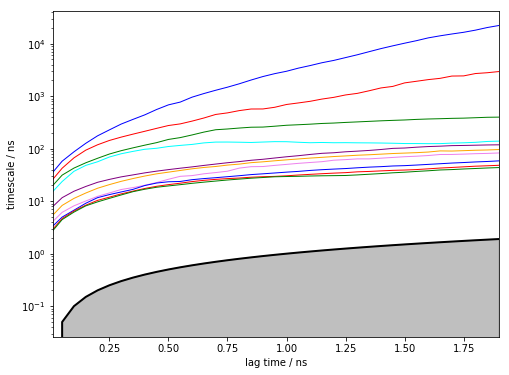

In [14]:
figure(figsize=(8,6))
ax=gca()
mplt.plot_implied_timescales(its, show_mean=False, ylog=True,  units='ns', linewidth=1,dt=0.01,ax=ax)
#ylim(0,200)
#savefig('its.png', format='png',dpi=720,bbox_inches="tight")

# Estimate MSM

In [15]:
msm_lag =100
M = msm.estimate_markov_model(dtrajs, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)
print(M.nstates)

fraction of states used =  1.0
fraction of counts used =  1.0
447


In [16]:
ck = M.cktest(4, mlags=10)

100%|██████████| 9/9 [00:20<00:00,  2.91s/it]                                 


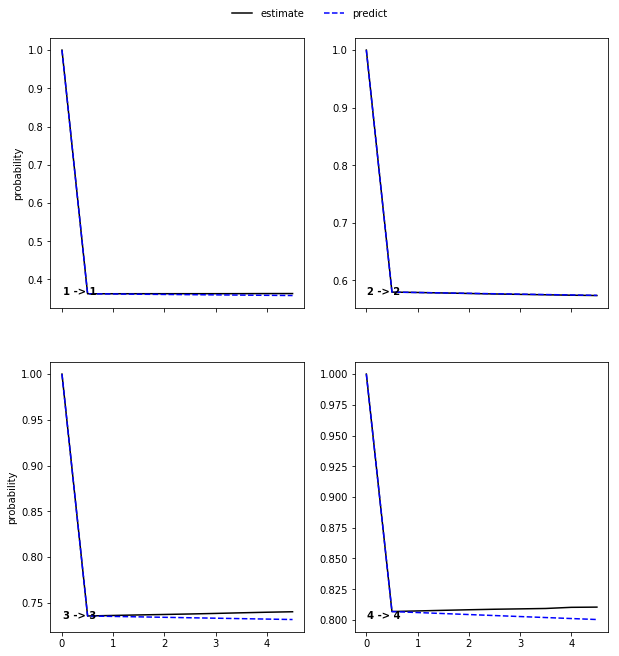

In [22]:
mplt.plot_cktest(ck, diag=True, figsize=(10,10), layout=(2,2), padding_top=0.05, y01=False, padding_between=0.2, dt=0.01, units='ns')
savefig('ck.png', format='png',dpi=720,bbox_inches="tight")

# test MSM


In [59]:
M = msm.bayesian_markov_model(dtrajs,50)



100%|██████████| 100/100 [00:14<00:00,  6.87it/s]               


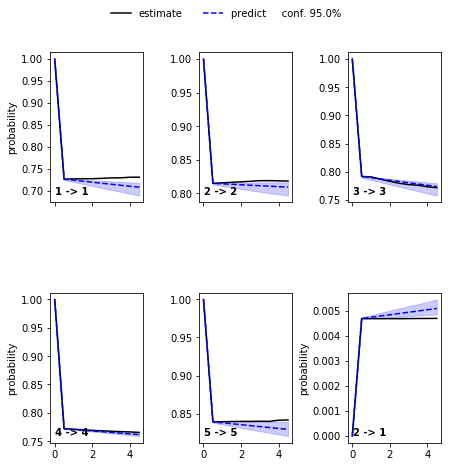

In [120]:
#ck = M.cktest(5,mlags=10,show_progress=False)
mplt.plot_cktest(ck, diag=True, figsize=(7,7), layout=(2,3), padding_top=0.1, y01=False, padding_between=0.6, dt=0.01, units='ns')
savefig('ck.png', format='png',dpi=720,bbox_inches="tight")

In [ ]:
nstates = 7
lags=200
its = msm.timescales_hmsm(dtrajs, nstates, lags=lags, errors='bayes', n_jobs=36,show_progress=False)
mplt.plot_implied_timescales(its, show_mean=False, units='ns', dt=0.005, linewidth=1)

# Coarse-grained kinetic Model using a Hidden Markov Model

In [25]:
M.nstates

447

In [60]:
hmm = M.coarse_grain(5)

In [61]:
hmm.stationary_distribution 

array([ 0.03659393,  0.23948029,  0.06627234,  0.5295001 ,  0.12815333])

In [126]:
help(mplt.plot_markov_model)

Help on function plot_markov_model in module pyemma.plots.networks:

plot_markov_model(P, pos=None, state_sizes=None, state_scale=1.0, state_colors='#ff5500', state_labels='auto', minflux=1e-06, arrow_scale=1.0, arrow_curvature=1.0, arrow_labels='weights', arrow_label_format='%2.e', max_width=12, max_height=12, figpadding=0.2, show_frame=False, ax=None, **textkwargs)
    Network representation of MSM transition matrix
    
    This visualization is not optimized for large matrices. It is meant to be
    used for the visualization of small models with up to 10-20 states, e.g.
    obtained by a HMM coarse-graining. If used with large network, the automatic
    node positioning will be very slow and may still look ugly.
    
    Parameters
    ----------
    P : ndarray(n,n) or MSM object with attribute 'transition matrix'
        Transition matrix or MSM object
    pos : ndarray(n,2), optional, default=None
        User-defined positions to draw the states on. If not given, will try
    

/home/denglei/anaconda2/envs/python36/lib/python3.6/site-packages/pyemma/plots/networks.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  if (Dx / max_width > Dy / max_height):


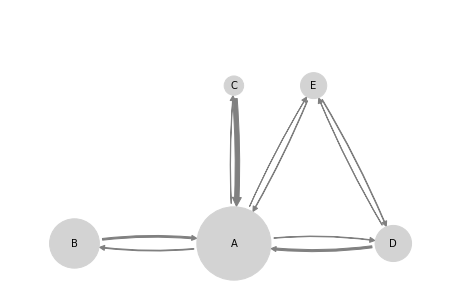

In [125]:
#pos=np.array([[-3, -4], [0, -5], [-4.2, 0.5], [0, 0]])
#state_labels = ['A','B','C','D','E']
state_labels = ['C','B','E','A','D']
pos=np.array([[4,4],[0,0],[6,4],[4,0],[8,0]])
#pos=np.array([[0, 4],[8,4],[6, 0],[4,4],[2, 0]])

figure(figsize=(8,5))
ax = gca()
mplt.plot_markov_model(hmm,minflux=4e-6,pos=pos,state_labels=state_labels,arrow_curvature=0.5,arrow_labels=None,
                       max_width=1, max_height=0,ax=ax,state_colors='#D3D3D3',state_scale=3,)
print()
#savefig('fig3.png', format='png',dpi=720,bbox_inches="tight")

In [105]:
sample = hmm.sample_by_observation_probabilities(5)

In [106]:
sample

array([ array([[   7, 6529],
       [   6, 2116],
       [  17,  538],
       [   5, 9248],
       [   7, 3137]]),
       array([[  12, 6419],
       [  18, 1313],
       [  18, 2033],
       [   4, 9395],
       [  14, 2324]]),
       array([[  10, 9248],
       [  10, 3759],
       [  10, 5568],
       [  10, 6786],
       [  10, 4035]]),
       array([[   9, 4919],
       [   5, 5173],
       [   5, 5192],
       [   9, 3322],
       [  14, 8404]]),
       array([[  13, 7214],
       [  13, 1784],
       [  11, 3629],
       [  14, 7750],
       [  11, 9899]])], dtype=object)

In [ ]:
#pos=np.array([[-3, -4], [0, -5], [-4.2, 0.5], [0, 0]])
#state_labels = ['A','B','C','D','E']
state_labels = ['A','E','D','C','B']
#pos=np.array([[0, 4], [2, 0], [4,4], [6, 0],[8,4]])
pos=np.array([[0, 4],[8,4],[6, 0],[4,4],[2, 0]])
figure(figsize=(8,4))
ax = gca()
mplt.plot_markov_model(hmm,pos=pos, minflux=4e-4,state_labels=state_labels,arrow_label_format='%.3f',max_width=10, max_height=10,ax=ax,
                       state_colors='#D3D3D3',state_scale=1)
savefig('fig3.png', format='png',dpi=720,bbox_inches="tight")

In [ ]:
hmm.sample_by_observation_probabilities(10)

In [ ]:
hmm_ = M.hmm(5)

In [ ]:
pos=np.array([[0, 4], [2, 0], [4,4], [6, 0],[8,4]])
figure(figsize=(8,4))
ax = gca()
mplt.plot_markov_model(hmm_, pos=pos,minflux=4e-4, arrow_label_format='%.3f',max_width=10, max_height=10,ax=ax,
                       state_colors='#D3D3D3',state_scale=0.5)
#savefig('fig3.png', format='png',dpi=720,bbox_inches="tight")

In [ ]:
hmm.metastable_sets

In [ ]:
num = 0
for i in t:
    num += len(i)

In [ ]:
num

In [ ]:
def func(seq):
    none_polar = '''GAVLMI '''
    pos_elec = '''KRH'''
    neg_elec = '''DE'''
    none_elec = '''STCPNQ'''
    polar = pos_elec+neg_elec+none_elec 
    aromatic = '''FYW'''
    count = {'none_polar':0,'pos_elec':0,'neg_elec':0,'none_elec':0,'polar':0,'aromatic':0}
    for s in seq:
        if s in none_polar:
            count['none_polar'] += 1
        if s in pos_elec:
            count['pos_elec'] += 1
        if s in neg_elec:
            count['neg_elec'] += 1
        if s in none_elec:
            count['none_elec'] += 1
        if s in polar:
            count['polar'] += 1
        if s in aromatic:
            count['aromatic'] +=1
    return count
seq1 = '''IVGGYTCGANTVPYQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGIQVRLGEDNINVVEGNEQFISASKS
IVHPSYNSNTLNNDIMLIKLKSAASLNSRVASISLPTSCASAGTQCLISGWGNTKSSGTSYPDVLKCLKA
PILSDSSCKSAYPGQITSNMFCAGYLEGGKDSCQGDSGGPVVCSGKLQGIVSWGSGCAQKNKPGVYTKVC
NYVSWIKQTIASN
'''
seq2 = '''IVGGYECKPYSQPHQVSLNSGYHFCGGSLVNENWVVSAAHCYKSRVEVRLGEHNIKVTEGSEQFISSSRV
IRHPNYSSYNIDNDIMLIKLSKPATLNTYVQPVALPTSCAPAGTMCTVSGWGNTMSSTADSNKLQCLNIP
ILSYSDCNNSYPGMITNAMFCAGYLEGGKDSCQGDSGGPVVCNGELQGVVSWGYGCAEPGNPGVYAKVCI
FNDWLTSTMASY'''
_3btk = func(seq1)
_1bzx = func(seq2)